# DC2 Playground

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pathlib

In [3]:
import torch
import torch.utils.data

In [4]:
import fitsio

## Locate Data

The data consists of simulated `calexp` images, one per sensor (with 189 sensors in the full focal plane - details [here](https://confluence.lsstcorp.org/display/LSWUG/Representation+of+a+Camera)). File names are:
```
calexp_<visit-number>-<band>-<raft>-<sensor>-<detector>.fits
```

In [10]:
class CalExpData(torch.utils.data.Dataset):
    """Wrapper for a directory containing a full focal plane of CalExps.
    """
    def __init__(self, path, stamp_size=48, stride=1, frac_lo=0., frac_hi=1., seed=123):
        self.path = pathlib.Path(path)
        assert self.path.exists()
        all_files = list(map(str, self.path.glob('*/calexp_*.fits')))
        num_files = len(all_files)
        print(f'Found {num_files} calexp images.')
        # Shuffle the images.
        gen = np.random.RandomState(seed=seed)
        gen.shuffle(all_files)
        # Use the requested subset.
        idx_lo = int(np.floor(frac_lo * num_files))
        idx_hi = int(np.floor(frac_hi * num_files))
        print(f'Using range [{idx_lo}:{idx_hi}]')
        self.files = all_files[idx_lo:idx_hi]
        num_files = len(self.files)
        # Load images into memory.
        for i, filename in enumerate(self.files):
            if i == 0:
                data = fitsio.read(filename, ext=1)
                self.flux = np.empty((num_files,) + data.shape, data.dtype)
                self.flux[0] = data
            else:
                self.flux[i] = fitsio.read(filename, ext=1)
        self.init_stamps(stamp_size, stride)

    def init_stamps(self, stamp_size, stride):
        self.stride = stride
        self.stamp_size = stamp_size
        # Determine the number of stamps available.
        nx, ny = self.flux.shape[1:]
        print(f'Image size is {nx} x {ny}.')
        self.nx_offsets = (nx - stamp_size) // stride
        self.ny_offsets = (ny - stamp_size) // stride
        self.num_stamps = len(self.files) * self.nx_offsets * self.ny_offsets
        
    def __len__(self):
        return self.num_stamps
    
    def __getitem__(self, stamp_idx):
        image_idx = stamp_idx // (self.nx_offsets * self.ny_offsets)
        offsets_idx = stamp_idx % (self.nx_offsets * self.ny_offsets)
        x_offset = (offsets_idx % self.ny_offsets) * self.stride
        y_offset = (offsets_idx // self.ny_offsets) * self.stride
        return self.flux[image_idx, x_offset:x_offset + self.stamp_size, y_offset:y_offset + self.stamp_size]

In [11]:
train_data = CalExpData('/media/data1/DESC/DC2/00006854-i', frac_hi=0.05, stride=8)

Found 189 calexp images.
Using range [0:9]
Image size is 4000 x 4072.


In [23]:
train_data.init_stamps(stamp_size=64, stride=32)

Image size is 4000 x 4072.


In [24]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=4)

In [25]:
def equalize(A, clip_percent=1):
    """Equalize the values of an array.
    The returned array has values between 0-1 such that clip_percent
    of the values are clipped symmetrically at 0 and 1, and the
    histogram of values between 0 and 1 is flat. This is a non-linear
    transformation and primarily useful for showing small variations
    over a large dynamic range.
    """
    A_flat = A.reshape(-1)
    n = len(A_flat)
    num_clip = round(n * clip_percent / 100.)
    num_clip_lo = num_clip // 2
    num_clip_hi = num_clip - num_clip_lo
    equalized = np.empty_like(A_flat, dtype=float)
    order = np.argsort(A_flat)
    equalized[order] = np.clip(
        (np.arange(n) - num_clip_lo) / float(n - num_clip), 0., 1.)
    return equalized.reshape(A.shape)

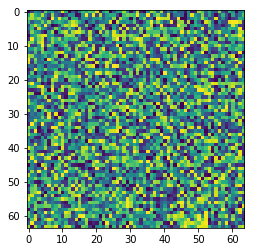

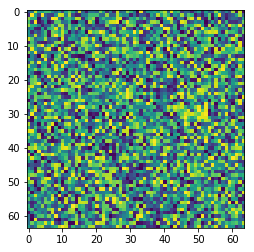

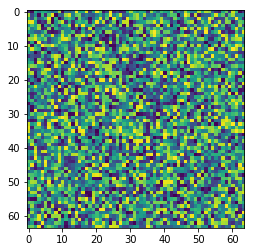

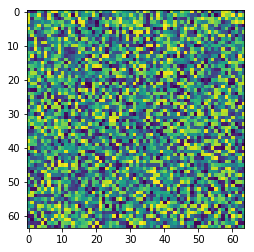

In [26]:
for i, batch in enumerate(train_loader):
    for img in batch.numpy():
        plt.imshow(equalize(img), interpolation='none')
        plt.show()
    break